# Train a VAE on L1000 Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd

sys.path.insert(0, "../../scripts")
from utils import load_data, infer_L1000_features
import matplotlib.pyplot as plt

from tensorflow import keras


from vae import VAE
from tensorflow.keras.models import Model, Sequential
import seaborn
import tensorflow as tf

In [2]:
# %load_ext nb_black

In [3]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [2]:
data_splits = ["train", "valid", "test", "complete"]
# data_splits = ["train", "valid","test"]
data_dict = load_data(data_splits, dataset="L1000")
# data_dict["train"] = data_dict["train"].reset_index(drop = True)
# data_dict["valid"] = data_dict["valid"].reset_index(drop = True)
# data_dict["test"] = data_dict["test"].reset_index(drop = True)
# data_dict["complete"] = data_dict["complete"][data_dict["complete"].cell_id == "A549"].reset_index(drop = True)

In [3]:
# Prepare data for training

meta_features = infer_L1000_features(data_dict["train"], metadata=True)
profile_features = infer_L1000_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(profile_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(profile_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(profile_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(profile_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")

In [4]:
#shuffle columns
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

In [7]:
# train_features_df = shuffle_each_column(train_features_df)
# valid_features_df = shuffle_each_column(valid_features_df)
# test_features_df = shuffle_each_column(test_features_df)

In [4]:
print(train_features_df.shape)
train_features_df.head(3)

(276780, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.30915,-0.45811,-0.112460,0.094465,0.15220,0.26364,0.35768,0.23983,0.31137,0.70382,...,-0.29516,-0.21383,-0.237290,0.30989,0.007832,-0.57513,-0.037422,-0.31153,-0.026483,-0.035361
1,-0.30412,-0.46788,-0.062801,0.115370,0.15534,0.28277,0.55894,0.26838,0.32415,0.70390,...,-0.25930,-0.66656,-0.244950,0.32765,-0.112650,-0.67223,0.004227,-0.23050,-0.027725,-0.106560
2,-0.24214,-0.41457,-0.172430,0.173650,0.24419,0.21529,0.45179,0.21111,0.26751,0.67411,...,-0.17748,-0.11334,0.088345,0.44357,-0.124280,-0.48827,-0.031880,-0.22529,-0.152190,-0.095751


In [5]:
print(valid_features_df.shape)
valid_features_df.head(3)

(34598, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.32377,-0.48676,-0.040063,0.079069,0.17556,0.23076,0.56264,0.26643,0.28305,0.70382,...,-0.26561,-0.21177,-0.15969,0.36090,-0.055990,-0.64508,0.040404,-0.61542,-0.055460,0.002830
1,-0.27674,-0.44999,-0.063546,0.132160,0.17491,0.23798,0.54144,0.22489,0.31491,0.67898,...,-0.31390,-0.21547,-0.23715,0.32892,-0.039005,-0.56867,0.019290,-0.24918,-0.021146,-0.042970
2,-0.25110,-0.39870,-0.016999,0.180420,0.20114,0.20474,0.50119,0.26414,0.23163,0.72167,...,-0.25484,-0.19533,-0.15682,0.37346,-0.051445,-0.61496,-0.010448,-0.33790,-0.022273,-0.062118


In [6]:
print(test_features_df.shape)
test_features_df.head(3)

(34598, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,-0.29015,-0.43945,-0.078535,0.12279,0.17539,0.23133,0.55234,0.23564,0.31848,0.71857,...,-0.28150,-0.21618,-0.24757,0.32205,-0.057950,-0.61827,-0.059178,-0.32006,-0.058405,-0.017248
1,-0.28751,-0.42101,-0.165140,0.13766,0.15864,0.22679,0.51885,0.25668,0.31265,0.70382,...,-0.26473,-0.19202,-0.21910,0.40778,-0.104580,-0.64058,-0.013573,-0.33499,-0.015683,-0.039037
2,-0.30807,-0.43907,-0.078535,0.10279,0.10317,0.20077,0.53096,0.23977,0.36560,0.70382,...,-0.26953,-0.18156,-0.21945,0.35713,-0.080955,-0.64818,-0.020032,-0.24117,-0.074538,-0.087869


In [7]:
print(complete_features_df.shape)
complete_features_df.head(3)

(345976, 978)


,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,0.22306,-0.43765,-0.239580,0.12350,0.15019,0.32246,0.54144,0.24364,0.31101,0.70382,...,-0.26576,-0.19081,-0.26988,0.36256,-0.059494,-0.69990,0.051617,-0.30179,0.107860,-0.079371
1,-0.29428,-0.31242,-0.087194,0.10253,0.18861,0.25744,0.54144,0.26467,0.33836,0.70382,...,-0.30688,-0.23647,-0.27758,0.34520,-0.054869,-0.58325,0.069114,-0.24282,-0.043908,-0.076082
2,-0.31171,-0.47030,-0.145470,0.15617,0.19679,0.17879,0.22852,0.20207,0.27981,0.70382,...,-0.31480,-0.18578,-0.20356,0.42749,-0.193510,-0.65741,0.048636,-0.33312,-0.024345,-0.072546


In [8]:
# VAE of one layer
# 100
encoder_architecture = [1000,1000]
decoder_architecture = [1000,1000]


In [18]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
# L1000_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=115,
#     batch_size=640,
#     encoder_batch_norm=False,
#     epochs=25,
#     learning_rate=0.001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1,
#     verbose=True,
# )

#FROM THE PAPER
# L1000_vae = VAE(
#     input_dim=train_features_df.shape[1],
#     latent_dim=100,
#     batch_size=512,
#     encoder_batch_norm=False,
#     epochs=20,
#     learning_rate=0.001,
#     encoder_architecture=encoder_architecture,
#     decoder_architecture=decoder_architecture,
#     beta=1,
#     verbose=True,
# )

L1000_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=20,
    batch_size=500,
    encoder_batch_norm=False,
    epochs=20,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)
L1000_vae.compile_vae()


In [19]:
L1000_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/20
554/554 [==============================] - 30s 53ms/step - loss: 19.7977 - val_loss: 10.5684
Epoch 2/20
554/554 [==============================] - 29s 52ms/step - loss: 10.5530 - val_loss: 10.1609
Epoch 3/20
554/554 [==============================] - 29s 52ms/step - loss: 10.0236 - val_loss: 10.0084
Epoch 4/20
554/554 [==============================] - 29s 52ms/step - loss: 9.9908 - val_loss: 9.9974
Epoch 5/20
554/554 [==============================] - 29s 52ms/step - loss: 9.9929 - val_loss: 9.9993
Epoch 6/20
554/554 [==============================] - 29s 52ms/step - loss: 9.5714 - val_loss: 9.4737
Epoch 7/20
554/554 [==============================] - 29s 52ms/step - loss: 9.4699 - val_loss: 9.4590
Epoch 8/20
554/554 [==============================] - 29s 52ms/step - loss: 9.4625 - val_loss: 9.4492
Epoch 9/20
554/554 [==============================] - 29s 52ms/step - loss: 9.4407 - val_loss: 9.4487
Epoch 10/20
554/554 [==============================] - 29s 51ms/step - loss:

In [20]:
L1000_vae.vae

In [21]:
# Save training performance
history_df = pd.DataFrame(L1000_vae.vae.history.history)
history_df

,loss,val_loss
0,13.073417,10.568362
1,10.522896,10.160945
2,10.011734,10.008381
3,10.000591,9.997396
4,9.988541,9.999318
5,9.503391,9.473726
6,9.460510,9.458978
7,9.449368,9.449187
8,9.442162,9.448685
9,9.436653,9.439744


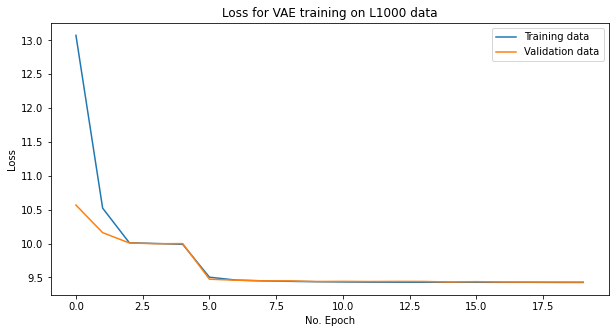

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on L1000 data")
# plt.ylabel("Binary cross entropy + KL Divergence")
plt.ylabel("Loss")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [23]:
# evaluating performance using test set
L1000_vae.vae.evaluate(test_features_df)

1082/1082 [==============================] - 5s 4ms/step - loss: 9.4916


9.491593360900879

In [16]:
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

832.9980710207644

<AxesSubplot:>

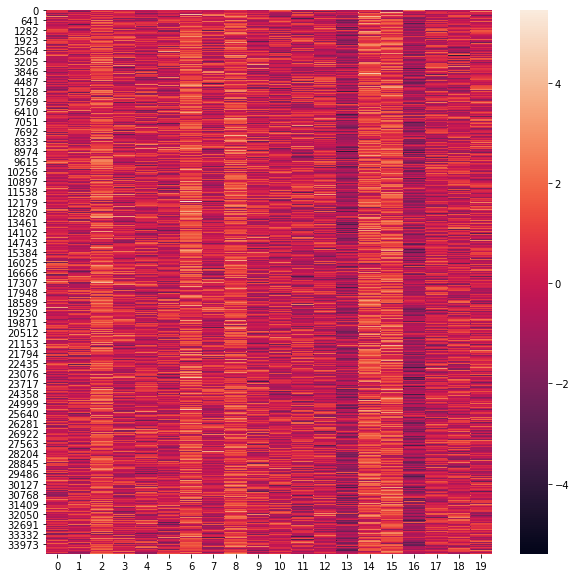

In [24]:
# latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = L1000_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

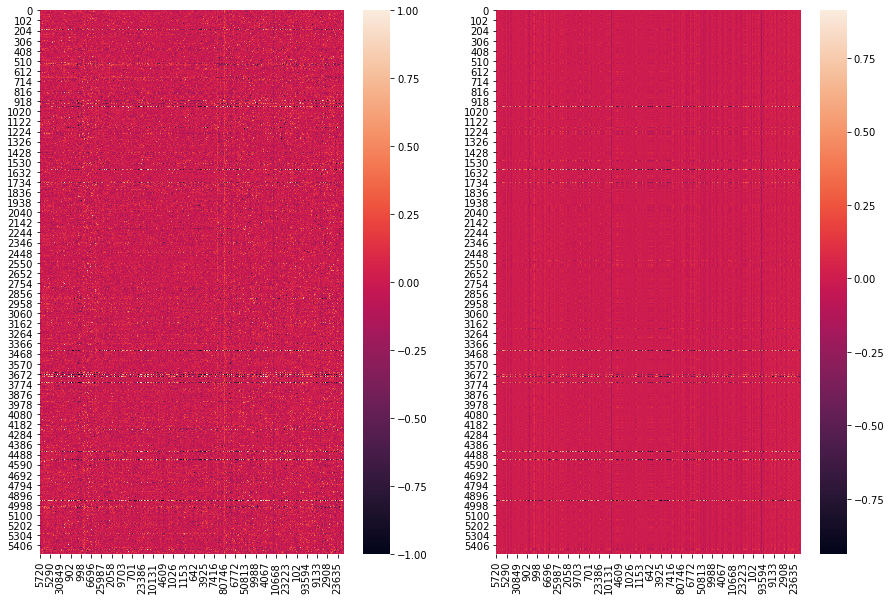

In [21]:
# original vs reconstructed heatmap
reconstruction = pd.DataFrame(
    L1000_vae.vae.predict(test_features_df), columns=profile_features
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
seaborn.heatmap(test_features_df, ax=ax1)
seaborn.heatmap(reconstruction, ax=ax2)
plt.show()

<AxesSubplot:>

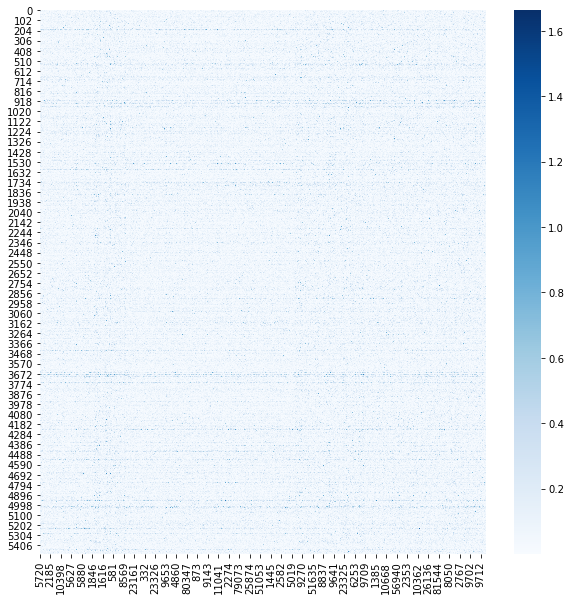

In [22]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

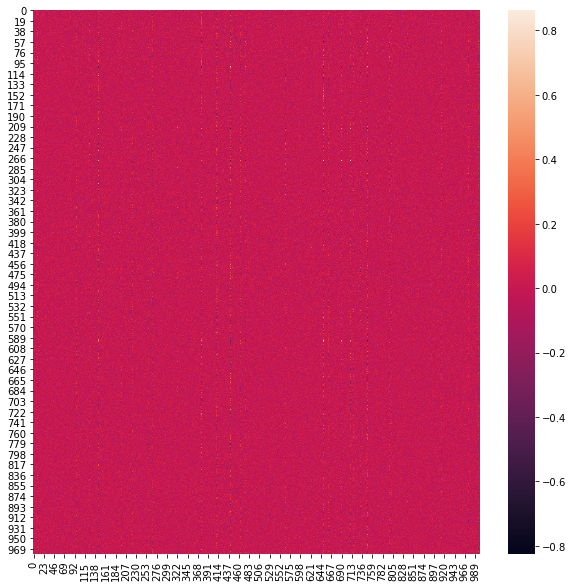

In [18]:
#encoder heatmap
weights = L1000_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [25]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/latent10.csv")

In [26]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder = L1000_vae.decoder_block["decoder"]
decoder.save('./level4')

INFO:tensorflow:Assets written to: ./level4/assets
